# Invasive Species Monitoring and the power of transfer learning

The goal of this notebook is to classify images of invasive plant species.

The data for this competition can be found [here](https://www.kaggle.com/c/invasive-species-monitoring).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. 
To get the data: <br>
`kaggle competitions download -c invasive-species-monitoring -p .` <br>

You have to install 7zz and do: <br>
`7zz x train.7z`

In [4]:
PATH = Path("/home/yinterian/data/invasive-species-monitoring/")
list(PATH.iterdir())

[PosixPath('/home/yinterian/data/invasive-species-monitoring/train.7z'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/test.7z'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/test'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train')]

In [5]:
list((PATH/"train").iterdir())[:10] 

[PosixPath('/home/yinterian/data/invasive-species-monitoring/train/2249.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/92.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/302.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/2031.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/1903.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/1605.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/352.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/654.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/1261.jpg'),
 PosixPath('/home/yinterian/data/invasive-species-monitoring/train/388.jpg')]

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

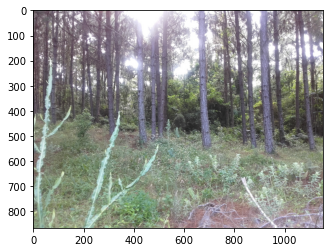

In [7]:
path = PATH/"train/2249.jpg"
im = read_image(path)
plt.imshow(im)

In [8]:
im = cv2.imread(str(path))
im.shape

(866, 1154, 3)

In [9]:
# let's look at the typical size of these images
path = PATH/"train"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]

In [10]:
np.unique(dims)

array([   3,  866, 1154])

Amazing! all images have the same size.

In [11]:
866/3.8, 1154/3.8

(227.89473684210526, 303.6842105263158)

## Data augmentation
Data augmentation is the most important way to avoid overfitting for image classification tasks.

In [12]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

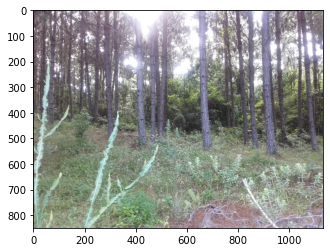

In [13]:
path = PATH/"train/2249.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

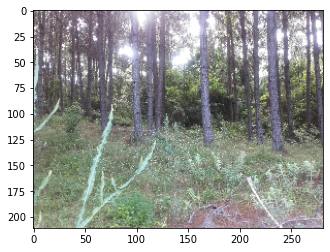

In [14]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (303, 227))
im2 = random_crop(im)
plt.imshow(im2, cmap='gray')

### Random Rotation (-10, 10) 

0.9267108413247183


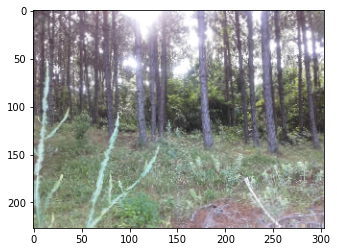

In [15]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

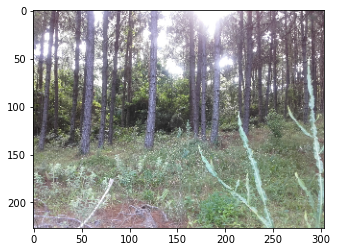

In [16]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [18]:
labels = pd.read_csv(PATH/"train_labels.csv")
labels.head()

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [19]:
# how many classes
np.unique(labels.invasive.values)

array([0, 1])

In [20]:
# ration of 1 / total
labels.invasive.values.sum()/len(labels)

0.6309368191721133

In [21]:
np.random.seed(3)
mask = np.random.random(len(labels)) < 0.8
train_labels = labels[mask].copy()
valid_labels = labels[~mask].copy()

In [22]:
len(labels), len(train_labels), len(valid_labels) 

(2295, 1860, 435)

## Resizing data

In [23]:
def resize_crop_image(path, sz=(303, 227)):
    im = read_image(path)
    im = center_crop(im)
    return cv2.resize(im, sz)

In [26]:
def resize_all_images(resize_path, org_path):
    (PATH/"train_303_227").mkdir(parents=True, exist_ok=True)
    files = [x for x in list(org_path.iterdir()) if x.suffix == ".jpg"]
    for f in files:
        f_name = f.parts[-1]    
        new_path = resize_path/f_name
        im = resize_crop_image(f)
        cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [28]:
# just run the first time
#resize_all_images(PATH/"train_303_227", PATH/"train")

## Dataset

In [29]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [30]:
class InvasiveDataset(Dataset):
    def __init__(self, files_path, labels, transform=False):
        self.num_files = len(labels)
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        row = self.labels.iloc[index,:]
        y = row["invasive"]
        file_name = str(row["name"]) + ".jpg"
        path = self.files_path/file_name
        x = read_image(path)
        if self.transform:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), y[None]

In [31]:
train_ds = InvasiveDataset(PATH/"train_303_227", labels=train_labels, transform=True)
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)

In [32]:
len(train_ds), len(valid_ds)

(1860, 435)

In [33]:
x, y = train_ds[0]
x.shape,y

((3, 211, 281), array([0]))

In [34]:
x, y = valid_ds[0]
x.shape,y

((3, 211, 281), array([1]))

In [35]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_ds, batch_size=64, num_workers=2)

In [36]:
len(train_ds)

1860

In [37]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [43]:
x, y = train_ds[0]
x.shape

(3, 211, 281)

In [45]:
np.rollaxis(x, 0, 3).shape

(211, 281, 3)

In [59]:
# transforming back to the original image
imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
im = np.rollaxis(x, 0, 3)
im = im*imagenet_stats[1]+ imagenet_stats[0]
im = im.astype(int)

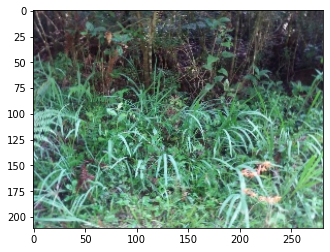

In [58]:
# run this multiple times to get different images
x, y = train_ds[0]
plt.imshow(im, cmap='gray')

In [60]:
x.shape,y

((3, 211, 281), array([0]))

## Model

In [61]:
resnet = models.resnet34(pretrained=True)
#resnet 

In [62]:
layers = list(resnet.children())
print(len(layers))
layers[-2:]

10


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [63]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [64]:
model = Net().cuda()

In [65]:
x, y = next(iter(train_dl))

In [66]:
x = x.cuda().float()
y = y.cuda().float()
x.shape

torch.Size([64, 3, 211, 281])

In [67]:
x_features = model.features1(x)
x_features.shape

torch.Size([64, 128, 27, 36])

In [68]:
x_features2 = model.features2(x_features)
x_features2.shape

torch.Size([64, 512, 7, 9])

In [69]:
x_features2 = F.relu(x_features2)

In [70]:
# AdaptiveAvgPool2d would do a similar job if the input is [64, 512, 10, 20]
# that is why this model will fit any input size
x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features2)
x_features_ave.shape

torch.Size([64, 512, 1, 1])

In [71]:
x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)
x_features_flatten.shape

torch.Size([64, 512])

In [72]:
y_hat = model(x)
y_hat.shape

torch.Size([64, 1])

In [73]:
# This loss combines a Sigmoid layer and the BCELoss in one single class. see
# https://pytorch.org/docs/master/nn.html#torch.nn.BCEWithLogitsLoss
F.binary_cross_entropy_with_logits(y_hat, y)

tensor(0.8772, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [74]:
y.shape

torch.Size([64, 1])

## Checking Loss function
Let's write the loss function from scratch in numpy to check the pytorch function.

In [75]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def binary_loss(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
binary_loss(1, 0.5)

0.6931471805599453

In [76]:
# example
y = np.array([1, 1, 0])
y_logit = np.array([10, 1, -1])
sigmoid(y_logit)

array([0.9999546 , 0.73105858, 0.26894142])

In [77]:
l = [binary_loss(y1, p1) for y1,p1 in zip(y, sigmoid(y_logit))]
l

[4.539889921682063e-05, 0.3132616875182228, 0.3132616875182228]

In [78]:
np.mean(l)

0.20885625797855414

In [79]:
F.binary_cross_entropy_with_logits(torch.FloatTensor(y_logit), torch.FloatTensor(y))

tensor(0.2089)

In [80]:
# here we use sigmoid
F.binary_cross_entropy(torch.sigmoid(torch.FloatTensor(y_logit)), torch.FloatTensor(y))

tensor(0.2089)

## Learning rate finder

From this paper https://arxiv.org/pdf/1506.01186.pdf. This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from 1e-5 to 0.012.

In [81]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [82]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))


def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=2):
    losses = []
    p = PATH/"model_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses    

In [85]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.02)

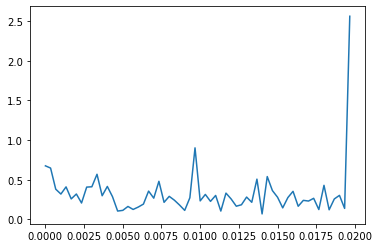

In [86]:
plt.plot(lrs, losses)
plt.show()

## Triangular learning rate training

In [96]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

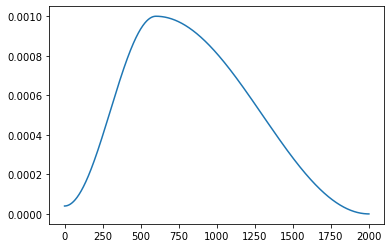

In [97]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [89]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [90]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_resnet34_{1:.0f}.pth".format(PATH, 100*val_acc)
            save_model(model, path)
            print(path)

In [91]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            pred = (out > 0.0).long()
            correct += pred.eq(y.data).sum().item()
            y = y.float()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total

## Training with triangular rates

In [92]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [93]:
model = Net().cuda()

In [94]:
val_metrics(model, valid_dl)

(3.8964928479030214, 0.48735632183908045)

In [98]:
(PATH/"models").mkdir(parents=True, exist_ok=True)

In [99]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 5)

train_loss 0.267 val_loss 54.414 val_acc 0.368
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_37.pth
train_loss 0.319 val_loss 2.756 val_acc 0.676
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_68.pth
train_loss 0.195 val_loss 0.432 val_acc 0.789
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_79.pth
train_loss 0.203 val_loss 0.166 val_acc 0.940
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.120 val_loss 0.134 val_acc 0.949
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_95.pth


In [100]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 8)

train_loss 0.265 val_loss 6.728 val_acc 0.855
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_86.pth
train_loss 0.186 val_loss 19.377 val_acc 0.646
train_loss 0.262 val_loss 1.351 val_acc 0.697
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_70.pth
train_loss 0.288 val_loss 0.315 val_acc 0.894
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_89.pth
train_loss 0.140 val_loss 0.446 val_acc 0.766
train_loss 0.121 val_loss 0.149 val_acc 0.945
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.086 val_loss 0.100 val_acc 0.961
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_96.pth
train_loss 0.068 val_loss 0.085 val_acc 0.970
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_97.pth


In [101]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 10)

train_loss 0.269 val_loss 0.612 val_acc 0.901
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_90.pth
train_loss 0.144 val_loss 2.404 val_acc 0.632
train_loss 0.260 val_loss 0.684 val_acc 0.770
train_loss 0.267 val_loss 0.261 val_acc 0.915
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_91.pth
train_loss 0.212 val_loss 0.301 val_acc 0.890
train_loss 0.159 val_loss 0.184 val_acc 0.936
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_94.pth
train_loss 0.130 val_loss 0.102 val_acc 0.961
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_96.pth
train_loss 0.110 val_loss 0.081 val_acc 0.972
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_97.pth
train_loss 0.089 val_loss 0.106 val_acc 0.975
train_loss 0.061 val_loss 0.077 val_acc 0.972
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_97.pth


In [102]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 15)

train_loss 0.227 val_loss 1.245 val_acc 0.531
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_53.pth
train_loss 0.125 val_loss 3.617 val_acc 0.632
train_loss 0.189 val_loss 1.307 val_acc 0.685
train_loss 0.184 val_loss 0.338 val_acc 0.910
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_91.pth
train_loss 0.126 val_loss 0.095 val_acc 0.961
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_96.pth
train_loss 0.093 val_loss 0.358 val_acc 0.897
train_loss 0.098 val_loss 0.189 val_acc 0.926
train_loss 0.113 val_loss 0.186 val_acc 0.917
train_loss 0.139 val_loss 0.147 val_acc 0.949
train_loss 0.074 val_loss 0.133 val_acc 0.956
train_loss 0.051 val_loss 0.086 val_acc 0.977
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_98.pth
train_loss 0.035 val_loss 0.055 val_acc 0.982
/home/yinterian/data/invasive-species-monitoring/models/model_resnet34_98.pth
train_loss 0.030 val_loss 0.049 val_acc 0.977
/home/yinter

## Load a model

In [103]:
PATH

PosixPath('/home/yinterian/data/invasive-species-monitoring')

In [104]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [106]:
# load model
model = Net().cuda()
p = PATH/"models/model_resnet34_98.pth"
load_model(model, p)

In [107]:
val_metrics(model, valid_dl)

(0.04884740532986049, 0.9770114942528736)

## Testing time augmentation
Testing time augmentation is a technique that uses data aumentation at test time to improve the test predictions. This usually helps but here our accuracy is too high.

In [108]:
valid_ds = InvasiveDataset(PATH/"train_303_227", labels=valid_labels)
valid_ds_trs = InvasiveDataset(PATH/"train_303_227", labels=valid_labels, transform=True)

In [66]:
# note that I am not shuffling the data loaders
batch_size = 32
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
valid_dl_trs = DataLoader(valid_ds_trs, batch_size=batch_size)

In [67]:
def val_arrays(model, dl):
    model.eval()
    preds = []
    ys = []
    for x, y in dl:
        x = x.cuda().float()
        out = model(x)
        pred = (out > 0.0).long()
        preds.append(pred.cpu().numpy())
        ys.append(y.numpy())
    return np.vstack(preds), np.vstack(ys)

In [68]:
def TTAaccuracy(model, valid_dl, valid_dl_trs, ndls=4):
    preds, ys = val_arrays(model, valid_dl)
    pred_tuples = [val_arrays(model, valid_dl_trs) for i in range(ndls)]
    tr_preds = [p for p,y in pred_tuples]
    pp = np.hstack(tr_preds + [preds])
    final_prob = pp.mean(1)
    final_prediction = final_prob > 0.5
    return (final_prediction[:, None] == ys).sum()/len(final_prediction)

In [69]:
TTAaccuracy(model, valid_dl, valid_dl_trs)

0.9839080459770115

## Lab
Can you get better accuracy?
* Change some of the hyperparameters (add dropout, increase the number of the hidden units)
* Increase the image resolution
* Modify the data augmentation to include other transformations

# References
This notebook is based on the implementation from fast.ai.